# Arize Phoenix Setup

In [13]:
from phoenix.otel import register

# configure the Phoenix tracer
tracer_provider = register(
  endpoint="http://localhost:6006/v1/traces",
  project_name="keys-langgraph-exp", # Default is 'default'
  auto_instrument=True # Auto-instrument your app based on installed OI dependencies
)

Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented


OpenTelemetry Tracing Details
|  Phoenix Project: keys-langgraph-exp
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: http://localhost:6006/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



# LangGraph Workflow with Tools

In [14]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

# State that will be maintained by the run within the graph
class State(TypedDict):
    # Messages is of type list, with additional metadata provided by add_messages
    # The add_messages defines the messages list state value to append rather than overwrite
    messages: Annotated[list, add_messages]

## Tools for LLM / Graph

### Tool 1: Simple Multiplier

In [15]:
def multiply(a: float, b: float) -> float:
    """
    Multiply two numbers and return the result.

    Args:
        a (float): The first number.
        b (float): The second number.
    
    Returns:
        float: The product of the two numbers.
    """

    return a * b

### Tool 2: Random Dad Joke Generator

In [16]:
import random
from typing import Literal

def get_random_dad_joke(category: Literal["scientist", "cat"]) -> str:
    """Get a random dad joke based on the specified category.
    
    Args:
        category (Literal["scientist", "cat"]): The category of the joke.

    Returns:
        str: A random dad joke.
    """
    scientist_jokes = [
        "Why did the physicist go to the beach? Because they wanted to study wave-particle duality!",
        "Why don't scientists trust atoms? Because they make up everything!",
        "Why did the biologist break up with the physicist? There was no chemistry!"
    ]
    
    cat_jokes = [
        "Why was the cat sitting on the computer? To keep an eye on the mouse!",
        "What do you call a pile of kittens? A meow-tain!",
        "Why did the cat join the Red Cross? To become a first aid kit!"
    ]
    
    if category == "scientist":
        return random.choice(scientist_jokes)
    elif category == "cat":
        return random.choice(cat_jokes)
    else:
        return "Invalid category. Please choose 'scientist' or 'cat'."

### Tool 3: Magic Calculation

Makes magic funny calculation to test multi-step tool calls.

In [17]:
def magic_calculation(x: float) -> float:
    """Performs a magic calculation on the input number.
    
    Args:
        x (float): The input number.

    Returns:
        float: The result of the magic calculation.
    """
    # Example magic calculation: square the number and add 42
    return (x ** 2) + 10

### Aggregate Tools

In [18]:
tools = [multiply, get_random_dad_joke, magic_calculation]

## LLM with Tools

In [19]:
from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv


load_dotenv()


ollama_llm = ChatOllama(model="qwen3:4b", temperature=0.7)
ollama_llm_with_tools = ollama_llm.bind_tools(tools)
gemini_llm = ChatGoogleGenerativeAI(model="models/gemini-flash-latest", temperature=0.7)
gemini_llm_with_tools = gemini_llm.bind_tools(tools)

def chatbot_with_tools(state: State):   
    return {"messages": [ollama_llm_with_tools.invoke(state["messages"])]}

## Build the graph and compile the chain

In [20]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Create the state graph
graph = StateGraph(State)

# Add the nodes
graph.add_node("chatbot_with_tools", chatbot_with_tools)
graph.add_node("tools", ToolNode(tools))

# Add edges
graph.add_edge(START, "chatbot_with_tools")
graph.add_conditional_edges(
    "chatbot_with_tools",
    # When the LLM response is tool calling, this condition will be true
    tools_condition,
    )
graph.add_edge("tools", END)
# Compile
chain = graph.compile()

## View the Graph

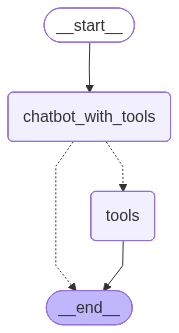

In [21]:
from IPython.display import Image, display

# Show Graph
display(Image(chain.get_graph().draw_mermaid_png()))

## Invoke the chain

In [22]:
# Invoke the chain (Does not require Tool Calling)
response = chain.invoke({"messages": "Why does sky look blue?"})
print(response)
print(response["messages"])
print(response["messages"][-1])
print(response["messages"][-1].content)
for m in response["messages"]:
    m.pretty_print()

{'messages': [HumanMessage(content='Why does sky look blue?', additional_kwargs={}, response_metadata={}, id='732da741-ea86-4011-a00f-de6625c4ca84'), AIMessage(content="The sky appears blue due to a phenomenon called Rayleigh scattering. When sunlight enters Earth's atmosphere, it interacts with molecules and small particles. Shorter wavelengths (like blue light) scatter more effectively than longer wavelengths, spreading the blue light in all directions. This is why the sky looks blue during the day. \n\nNo applicable function calls were needed for this explanation.", additional_kwargs={}, response_metadata={'model': 'qwen3:4b', 'created_at': '2026-01-04T14:19:08.927732Z', 'done': True, 'done_reason': 'stop', 'total_duration': 47524491800, 'load_duration': 386588900, 'prompt_eval_count': 286, 'prompt_eval_duration': 297832600, 'eval_count': 1863, 'eval_duration': 45296171700, 'logprobs': None, 'model_name': 'qwen3:4b', 'model_provider': 'ollama'}, id='lc_run--019b895f-9559-7730-8f7c-e

In [23]:
# Invoke the chain (Requires Tool Calling)
response = chain.invoke({"messages": "What is 12 multiplied by 7?"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 12 multiplied by 7?
================================== Ai Message ==================================
Tool Calls:
  multiply (d498be76-0438-44dc-82c3-e7ed4acd8cc2)
 Call ID: d498be76-0438-44dc-82c3-e7ed4acd8cc2
  Args:
    a: 12
    b: 7
================================= Tool Message =================================
Name: multiply

84.0


In [24]:
# Invoke the chain (Requires Tool Calling)
response = chain.invoke({"messages": "Tell me a cat dad joke."})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Tell me a cat dad joke.
================================== Ai Message ==================================
Tool Calls:
  get_random_dad_joke (5b5a9c75-d5da-4a0d-b03c-3d3e7207700a)
 Call ID: 5b5a9c75-d5da-4a0d-b03c-3d3e7207700a
  Args:
    category: cat
================================= Tool Message =================================
Name: get_random_dad_joke

What do you call a pile of kittens? A meow-tain!


In [25]:
# Invoke the chain (Requires Tool Calling - Multi Steps)
response = chain.invoke({"messages": "Multiply 5 by 1.5 and then multiply the result by 3."})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 5 by 1.5 and then multiply the result by 3.
================================== Ai Message ==================================

The user has asked to multiply 5 by 1.5 and then multiply the result by 3. To fulfill this request using the available functions, the assistant must make two sequential calls to the `multiply` function.

1. **First Call**: Multiply 5 and 1.5 to get the intermediate result (7.5).
2. **Second Call**: Multiply the result from the first call (7.5) by 3 to get the final result (22.5).

Although the assistant does not know the exact value of the intermediate result (7.5) until the first call is made, the problem context allows for the second tool call to be expressed with the expected value of the intermediate result. This is a standard practice in such scenarios where the assistant is expected to generate the full sequence of tool calls based on the user's request.

---

**Fina

In [26]:
# Invoke the chain (Requires Tool Calling - Multiple Steps & LLM can not predict the result without tool calls)
response = chain.invoke({"messages": "Perform magic calculation on 4 and then perform magic calculation on the result again."})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Perform magic calculation on 4 and then perform magic calculation on the result again.
================================== Ai Message ==================================
Tool Calls:
  magic_calculation (18210476-271f-4c70-8e79-514cf245bd4c)
 Call ID: 18210476-271f-4c70-8e79-514cf245bd4c
  Args:
    x: 4
================================= Tool Message =================================
Name: magic_calculation

26.0


In [27]:
# Invoke the chain (Requires Multiple Discrete Tool Calling)
response = chain.invoke({"messages": "What is 12 multiplied by 7 and then tell me a cat dad joke?"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 12 multiplied by 7 and then tell me a cat dad joke?
================================== Ai Message ==================================
Tool Calls:
  multiply (f22d181e-2f31-4029-bbd9-bbcf1d911e64)
 Call ID: f22d181e-2f31-4029-bbd9-bbcf1d911e64
  Args:
    a: 12
    b: 7
  get_random_dad_joke (f0d12cf3-b463-4ea4-b7b1-2be7e82a27fe)
 Call ID: f0d12cf3-b463-4ea4-b7b1-2be7e82a27fe
  Args:
    category: cat
================================= Tool Message =================================
Name: multiply

84.0
================================= Tool Message =================================
Name: get_random_dad_joke

Why did the cat join the Red Cross? To become a first aid kit!


# LangGraph Workflow with ReACT

## Graph for ReACT

In [28]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Create the state graph
react_graph = StateGraph(State)

# Add the nodes
react_graph.add_node("chatbot_with_tools", chatbot_with_tools)
react_graph.add_node("tools", ToolNode(tools))

# Add edges
react_graph.add_edge(START, "chatbot_with_tools")
react_graph.add_conditional_edges(
    "chatbot_with_tools",
    # When the LLM response is tool calling, this condition will be true
    tools_condition,
    )
# Loop back to tools node for multiple tool calls
react_graph.add_edge("tools", "chatbot_with_tools")
# Compile
react_chain = react_graph.compile()

## View the ReACT Graph

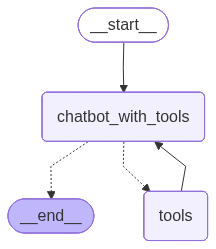

In [29]:
from IPython.display import Image, display

# Show Graph
display(Image(react_chain.get_graph().draw_mermaid_png()))

## Invoke the ReACT Chain

In [30]:
# Invoke the react_chain (Requires Repeated Tool Calling)
# The graph available at this point can make multiple tool calls in a single run as the graph loops back
# to the chatbot_with_tools node after each tool call.
response = react_chain.invoke({"messages": "What is 12 multiplied by 7 and then tell me a cat dad joke?"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 12 multiplied by 7 and then tell me a cat dad joke?
================================== Ai Message ==================================
Tool Calls:
  multiply (6b1d8d0c-9ed7-46d5-bde9-144b6e5454a9)
 Call ID: 6b1d8d0c-9ed7-46d5-bde9-144b6e5454a9
  Args:
    a: 12
    b: 7
  get_random_dad_joke (ba5d860c-f49c-49dd-978e-2c7414829c0d)
 Call ID: ba5d860c-f49c-49dd-978e-2c7414829c0d
  Args:
    category: cat
================================= Tool Message =================================
Name: multiply

84.0
================================= Tool Message =================================
Name: get_random_dad_joke

Why was the cat sitting on the computer? To keep an eye on the mouse!
================================== Ai Message ==================================

12 multiplied by 7 is **84**. Here's a cat dad joke for you:  
*Why was the cat sitting on the computer? To keep an eye on the mouse!* 😺


In [31]:
# Invoke the react_chain (Requires Tool Calling - Multiple Steps)
response = react_chain.invoke({"messages": "Multiply 5 by 1.5 and then multiply the result by 3."})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 5 by 1.5 and then multiply the result by 3.
================================== Ai Message ==================================

The user's query requires two sequential multiplication steps: first multiplying 5 by 1.5, then multiplying the result by 3. Since the `multiply` function takes exactly two arguments and the assistant does not yet have the intermediate result (7.5), it can only generate the **first tool call** to initiate the process. The second tool call would be generated after the system returns the result of the first multiplication.

**Response:**
```json
{
  "function": "multiply",
  "arguments": {
    "a": 5,
    "b": 1.5
  }
}
```


In [32]:
# Invoke the react_chain (Requires Tool Calling - Multiple Steps & LLM can not predict the result without tool calls)
response = react_chain.invoke({"messages": "Perform magic calculation on 4 and then perform magic calculation on the result again."})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Perform magic calculation on 4 and then perform magic calculation on the result again.
================================== Ai Message ==================================
Tool Calls:
  magic_calculation (8b6df4f1-18fc-4fcc-aad9-81dcf8709aa8)
 Call ID: 8b6df4f1-18fc-4fcc-aad9-81dcf8709aa8
  Args:
    x: 4
================================= Tool Message =================================
Name: magic_calculation

26.0
================================== Ai Message ==================================
Tool Calls:
  magic_calculation (98df09b5-d00c-4b3c-82dd-9e1fb413898a)
 Call ID: 98df09b5-d00c-4b3c-82dd-9e1fb413898a
  Args:
    x: 26
================================= Tool Message =================================
Name: magic_calculation

686.0
================================== Ai Message ==================================

The result of performing the magic calculation on 4 followed by the result again is **686.0**

## Stream node outputs

In [33]:
async for chunk in react_chain.astream({"messages": "What is 12 multiplied by 7 and then tell me a cat dad joke and finally perform magic calculation on 3."}):
    print(chunk)

{'chatbot_with_tools': {'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:4b', 'created_at': '2026-01-04T14:27:16.1531345Z', 'done': True, 'done_reason': 'stop', 'total_duration': 12155953500, 'load_duration': 380532000, 'prompt_eval_count': 306, 'prompt_eval_duration': 230336600, 'eval_count': 617, 'eval_duration': 11096178300, 'logprobs': None, 'model_name': 'qwen3:4b', 'model_provider': 'ollama'}, id='lc_run--019b8967-8eb5-7072-87b6-d3f555165e6c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 12, 'b': 7}, 'id': 'a3ed05f9-e558-47dc-a46e-03027ebae5cb', 'type': 'tool_call'}, {'name': 'get_random_dad_joke', 'args': {'category': 'cat'}, 'id': 'f3db6e1f-9d70-4d69-81a3-25618aadb3a0', 'type': 'tool_call'}, {'name': 'magic_calculation', 'args': {'x': 3}, 'id': 'd64e5014-4cbe-4af5-b79e-c48b9ec7e2d5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 306, 'output_tokens': 617, 'total_tokens': 923})]}}
{'tools': {'messages': [ToolMessage(content